In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import numpy as np
from scipy.interpolate import interp1d
from scipy.io import readsav

import re

from astropy.cosmology import FlatLambdaCDM
from astropy import units as u
import astropy 

from matplotlib.pylab import *
import matplotlib.pyplot as plt 
from matplotlib.ticker import FuncFormatter
from matplotlib.ticker import NullFormatter

rcParams['figure.figsize'] = (10,8)
rcParams['font.size'] = 22

import sys
sys.path.append('/Users/earnric/Google Drive/ASU/Codes/PythonCode/modules')
import loadfilt as lf
import igm as lyA
import buildFluxTables as bft

import linecache
import os
import subprocess
import glob
import gc

In [ ]:
def log_formatter(x,pos):
    return format(np.log10(x), '.0f')
logfmt  = FuncFormatter(log_formatter)

def log_GHzFormatter(x,pos):
    return format(np.log10(x)-9.0, '.0f')
logGHzfmt  = FuncFormatter(log_GHzFormatter)

def GHzFormatter(x,pos):
    return format(x/1e9, '.2e')
GHzfmt  = FuncFormatter(GHzFormatter)

def div_formatter(x,pos):
    return format(x/1000, '.1f')
divfmt  = FuncFormatter(div_formatter)

nullfmt = NullFormatter()
labelsize = 24

In [ ]:
# Setup the cosmology used in the runs
# This provides comoving distance, lumin distance, etc... 
# THis is Seth's cosmology
cosmo = FlatLambdaCDM(H0=73.2, Om0=0.24, Ob0=0.0449,name='myCosmo')

In [ ]:
cosmo.luminosity_distance(z=1.0)
# Matches Ned's calc: The luminosity distance DL is 6560.5 Mpc or 21.398 Gly. 

In [ ]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
lamRange = np.logspace(1.95,5.7,5500)
ax.plot(lamRange,lyA.lyTauC(4.0)(lamRange),'k-',
        lamRange,lyA.lyTauC(6)(lamRange),'y-',
        lamRange,lyA.lyTauC(8)(lamRange),'g-',
        lamRange,lyA.lyTauC(10)(lamRange),'k-')
ax.set_xlim([4000,16500])
ax.set_ylim([1e-9,1.1])
ax.set_ylim([0,1.1])
#ax.set_yscale('log')
ax.set_ylabel(r'$e^{-\tau}$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)


In [ ]:
fig = plt.figure(figsize=(10,4))
ax = plt.axes()
lamRange = np.logspace(1.95,5.7,5500)
ax.plot(lamRange,lyA.lyTauC(2.0)(lamRange),'k-',
        lamRange,lyA.lyTauC(2.5)(lamRange),'y-',
        lamRange,lyA.lyTauC(3.5)(lamRange),'g-',
        lamRange,lyA.lyTauC(4.5)(lamRange),'k-')
ax.set_xlim([1200,8500])
ax.set_ylim([1e-9,1.1])
ax.set_ylim([0,1.1])
#ax.set_yscale('log')
ax.set_ylabel(r'$e^{-\tau}$', size=labelsize)
ax.set_xlabel(r'$\lambda_{obs}\; [\AA/1000]$', size=labelsize)
ax.grid(b=True, which='major', color='b', linestyle='--')
ax.xaxis.set_major_formatter(divfmt)
ax.set_title(r'Ly-$\alpha$ & line absorp',size=labelsize)


# Load SB99 data... 

In [6]:
# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
# REMEMBER, SB99 data is for a population of 1e6 M_sun
# THIS IS WHY I HAVE "-6" when constructing the flux per wavelen below... 
SB99Path = '/Users/earnric/OneDrive/Software-Models/STARBURST99/STARBURST99-runs/' # Home computer dir... 
SB99Dirs = ['padova0004-op/','padova004-op/','padova008-op/','padova02-op/'] # Dense SED (in age)
Zs       = [0.0004, 0.004, 0.008, 0.02]
SB99FilePat = 'padova*.spectrum1'

# SB99 format:     TIME [YR]    WAVELENGTH [A]   LOG TOTAL  LOG STELLAR  LOG NEBULAR  [ERG/SEC/A]
for i, (Z, SB99Dir) in enumerate(zip(Zs,SB99Dirs)):
    SB99FilePattern = SB99Path + SB99Dir + SB99FilePat 
    SB99Files   = glob.glob(SB99FilePattern)  # All the files in the dir... should be one!
    if len(SB99Files) != 1:
        print('Error: too many files in an SB99 dir! - ',SB99Path + SB99Dir)
        sys.exit()
    SB99Data    = np.loadtxt(SB99Files[0],skiprows=6)
    if i == 0:
        SB990004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 1:
        SB99004 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 2:
        SB99008 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    elif i == 3:
        SB9902 = np.dstack((np.log10(SB99Data[:,0]),SB99Data[:,1],10**(SB99Data[:,2]-6.0))).reshape(len(SB99Data[:,1]),3)
    # We now have:
    # [[log age, waveln, flux], [], ...]


In [12]:
np.unique(SB99004[:,0])[0:20]

array([ 4.        ,  5.70757018,  6.00432137,  6.17897695,  6.30319606,
        6.39967372,  6.4785665 ,  6.54530712,  6.60314437,  6.65417654,
        6.69983773,  6.7411516 ,  6.77887447,  6.81358099,  6.84571802,
        6.87563994,  6.90363252,  6.92992956,  6.95472479,  6.97818052])

In [2]:
jwstFilters   = lf.loadJWSTFilters(suppress=True)
hubbleFilters = lf.loadHubbleFilters(suppress=True)
jhkFilters    = lf.loadJHKFilters(suppress=True)

In [4]:
[aFilt for aFilt in jwstFilters]

['f210m',
 'f115w',
 'f444w',
 'f335m',
 'f250m',
 'f150w',
 'f430m',
 'f300m',
 'f162m',
 'f070w',
 'f182m',
 'f410m',
 'f480m',
 'f200w',
 'f460m',
 'f356w',
 'f140m',
 'f277w',
 'f090w',
 'f360m']

The following computes the area under each of the filter curves so we can use the value in
normalizing the flux. We only want to do this once, so I've pulled it out of the main loop

_Can I do this here? I think I have to do this in the redshifted reference frame._

In [109]:
# Computer area in the filter curves (using Hz) for flux normalization
fullLamRange = arange(90,1600000) * u.angstrom
freq = (fullLamRange[::-1]).to(u.Hz, equivalencies=u.spectral()) # Reverse array order
# jhkNorms  = {aFilt: np.trapz(jhkFilters[aFilt](fullLamRange[::-1])/freq,freq).value for aFilt in jhkFilters}
# jwstNorms = {aFilt: np.trapz(jwstFilters[aFilt](fullLamRange[::-1])/freq,freq).value for aFilt in jwstFilters}
# hubbNorms = {aFilt: np.trapz(hubbleFilters[aFilt](fullLamRange[::-1])/freq,freq).value for aFilt in hubbleFilters}
# print(jwstNorms)
jhkNorms  = [np.trapz(jhkFilters[aFilt](fullLamRange[::-1])/freq,freq).value for aFilt in jhkFilters]
jwstNorms = [np.trapz(jwstFilters[aFilt](fullLamRange[::-1])/freq,freq).value for aFilt in jwstFilters]
hubbNorms = [np.trapz(hubbleFilters[aFilt](fullLamRange[::-1])/freq,freq).value for aFilt in hubbleFilters]

# Here's the main loop
Here we compute the flux in each of the filters. The values are computed as 

$\frac{\int_{-\infty}^\infty{f(\nu) R(\nu)/\nu d\nu}}{\int_{-\infty}^\infty{d\nu/\nu C R}}$

In [19]:
redshifts    = [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
# redshifts    = [2.0,3.0,14.0,15.0]
sb99List  = [SB990004, SB99004, SB99008, SB9902]
sb99Names = ["SB990004", "SB99004", "SB99008", "SB9902"]
# sb99List  = [SB9902]
# sb99Names = ["SB9902-TEST"]
hdr = 'LogAge, redshift, '
hdr += ', '.join([jFilt for jFilt in jwstFilters])
hdr += ', '
hdr += ', '.join([hFilt for hFilt in hubbleFilters])
hdr += ', '
hdr += ', '.join([jFilt for jFilt in jhkFilters])
fmtStr = '%.4f, %.1f, '
fmtStr += ', '.join(['%.4e' for ii in arange(len(jwstFilters)+len(hubbleFilters)+len(jhkFilters))]) 
print(hdr)
for sb99Data, fname in zip(sb99List,sb99Names): # Loop over SEDs for each Z
    ages = np.unique(sb99Data[:,0]) # Get the list of ages
    # Get the log age, wavelength & Luminosity/s/Ang
    allAges = sb99Data[:,0]
    wavelns = sb99Data[:,1] * u.Angstrom
    LperA   = sb99Data[:,2] * u.erg / u.second / u.angstrom
    for z in redshifts:
        prevAge = 0.0
        outfile = []
        print("working {} at z={:.1f}".format(fname,z))
        absorb = lyA.lyTauC(z) # Create a lyman forest absorption function for z... ***** NEW truncated absorption
        for age in ages: # Once for each age group in the list
            if age - prevAge < 0.025:
                continue # We don't super-tight spacing in age... 
            print("log age={:.4f}".format(age))
            prevAge = age
            ageCond = (allAges == age) # select records based on log age field... 
            # Convert to freq & Lumin/s/Hz
            freq = (wavelns[ageCond][::-1]).to(u.Hz, equivalencies=u.spectral()) # Reverse array order
            LperHz = (LperA[ageCond] * wavelns[ageCond]**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Reverse array order...

            rsWaveln, rsLperA  = lyA.rsSEDwavelen(wavelns[ageCond], LperA[ageCond], z) # Redshift SED in wavelen
            rsFreq,   rsLperHz = lyA.rsSEDfreq(freq, LperHz, z)      # Redshift SED in freq
            lyForFluxHz = (rsLperHz * absorb(rsWaveln[::-1]))        # Do Lyman forest aborption in redshifted frame. This is how absorb works
            
            rsWavelnOneAge    = rsWaveln
            rsFreqOneAge      = rsFreq
            lyForFluxHzOneAge = lyForFluxHz
            # Create first part [log age, z, ...]
            # Flux is in erg/s/Hz/cm^2
            # Verified that filter order here is same as header ordering!
            jwstFlux = np.array([(np.trapz(jwstFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in jwstFilters])
            jwstFlux = np.divide(jwstFlux,jwstNorms).tolist()
            jwstFlux[jwstFlux < 1e-199] = 1e-199
            
            hubbFlux = np.array([(np.trapz(hubbleFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in hubbleFilters])   
            hubbFlux = np.divide(hubbFlux,hubbNorms).tolist()
            hubbFlux[hubbFlux < 1e-199] = 1e-199
            
            jhkFlux = np.array([(np.trapz(jhkFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in jhkFilters])
            jhkFlux = np.divide(jhkFlux,jhkNorms).tolist()
            jhkFlux[jhkFlux < 1e-199] = 1e-199

            aLine = [age] + [z] + jwstFlux + hubbFlux + jhkFlux
            outfile.append(aLine)
        filename = fname + "_" + str(z) + ".gz"
        print('writing {}'.format(filename))
        np.savetxt(filename, outfile, fmt=fmtStr, delimiter=', ', header=hdr)

LogAge, redshift, f090w, f250m, f460m, f140m, f480m, f277w, f162m, f410m, f200w, f210m, f070w, f182m, f335m, f115w, f300m, f360m, f150w, f430m, f444w, f356w, F160W_WFC3, F105W_WFC3, F435W_ACS, F225W_WFC3, F775W_ACS, F336W_WFC3, F606W_ACS, F098M_WFC3, F125W_WFC3, F275W_WFC3, F850LP_ACS, Ks, H, J
working SB990004 at z=2.0
log age=4.0000
log age=5.7076
log age=6.0043
log age=6.1790
log age=6.3032
log age=6.3997
log age=6.4786
log age=6.5453
log age=6.6031
log age=6.6542
log age=6.6998
log age=6.7412
log age=6.7789
log age=6.8136
log age=6.8457
log age=6.8756
log age=6.9036
log age=6.9299
log age=6.9782
log age=7.0216
log age=7.0611
log age=7.0973
log age=7.1307
log age=7.1617
log age=7.1906
log age=7.2177
log age=7.2433
log age=7.2790
log age=7.3120
log age=7.3426
log age=7.3713
log age=7.3981
log age=7.4234
log age=7.4550
log age=7.4844
log age=7.5120
log age=7.5379
log age=7.5683
log age=7.5967
log age=7.6234
log age=7.6485
log age=7.6768
log age=7.7034
log age=7.7284
log age=7.7560
log

In [20]:
np.power(10,[6.0043,6.179,6.3032])

array([ 1009950.29412032,  1510080.15416415,  2010018.24711369])

# Schaerer

In [21]:
gc.collect()

42

In [9]:
# jwstFilters   = lf.loadJWSTFilters(suppress=True)
# hubbleFilters = lf.loadHubbleFilters(suppress=True)
# jhkFilters    = lf.loadJHKFilters(suppress=True)

lamRange      = np.logspace(1.95,5.7,5500)

schaererPath = '/Users/earnric/Research/Research-Observability/Software-Models/Schaerer/'
schaererDirs = ['pop3_TA/','pop3_TE/','e-70_mar08/','e-50_mar08/']
# schaererDirs = ['pop3_TAtest/']
Zs           = [0.0, 0.0, 1.0e-7, 1.0e-5]
schaererPopFilePattern  = 'pop3_ge0_log?_500_001_is5.[0-9]*' # is5 files have ages in step of 1 Myr
schaererLowZFilePattern = 'e-?0_sal_100_001_is2.[0-9]*'      # is2 files have ages in step of 0.05 dex

# Load the schaerer files... 
# Note that due to spacing (in age), there are sometimes two files that 
# are SEDS for the same time-stamp! Skip the second one (and third!)
lastAge = 0.0
for i, (Z, schaererDir) in enumerate(zip(Zs,schaererDirs)):
    if schaererDir.startswith('pop3'):
        schaererFilePattern = schaererPath + schaererDir + schaererPopFilePattern  # Pop III files, 1 Myr spacing
    else:
        schaererFilePattern = schaererPath + schaererDir + schaererLowZFilePattern # Low Z files, 0.05 dex spacing

    schaererFiles   = glob.glob(schaererFilePattern)  # All the files in the dir... 
    schaererFiles   = [a for a in schaererFiles if not re.search('\.[1-2][0-9][b]*$', a)] # remove .1? and .2? files
    schaererAges    = [linecache.getline(file,13) for file in schaererFiles]    # Get the line with the (log) age... 
    schaererAges    = np.array([float(sa[30:]) for sa in schaererAges],dtype=float)         # Log age starts at position 30

    schaererData    = np.array([np.loadtxt(file,skiprows=16) for file in schaererFiles])
    ageSortIndxes   = schaererAges.argsort()          # Array of indices to sort things by age...
    
    schaererData    = schaererData[ageSortIndxes]
    schaererAges    = schaererAges[ageSortIndxes]
    print(len(schaererAges),schaererAges)

    # Ignore data files with the same age! This occurs in the popIII dirs
    # because the timestep is smaller than the age-resolution printed in the file
    # Hence we get 2 files with different data but the same time stamp
    lastAge = 0.0
    schaererDataGood = []
    schaererAgesGood = []
    for ii,(sd,age) in enumerate(zip(schaererData,schaererAges)):
        if age == lastAge:
            # Remove it
            continue
        lastAge = age
        schaererDataGood.append(sd)
        schaererAgesGood.append(float(age))
    
    # The following builds an array of arrays (one for each age) with each array's entries:
    # log age, Z, waveln, lum/A
    allSchaererData = [np.insert(sed[:,[0,2]],[0],[[anAge] for ii in range(0,len(sed))], axis=1) 
        for anAge,sed in zip(schaererAgesGood, schaererDataGood)]
    allSchaererData = np.array(allSchaererData).reshape(len(allSchaererData)*len(allSchaererData[0]),3)
    if i == 0:
        pop3TA = allSchaererData # may need a np.copy(...) here... ??
    elif i == 1:
        pop3TE = allSchaererData
    elif i == 2:
        Zem7 = allSchaererData
    elif i == 3:
        Zem5 = allSchaererData
    # We now have:
    # [[log age, waveln, flux], [], ...]

1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
1001 [ 4.     6.004  6.303 ...,  8.999  9.     9.   ]
112 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55
  4.6   4.65  4.7   4.75  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15
  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55  5.6   5.65  5.7   5.75
  5.8   5.85  5.9   5.95  6.    6.05  6.1   6.15  6.2   6.25  6.3   6.35
  6.4   6.45  6.5   6.55  6.6   6.65  6.7   6.75  6.8   6.85  6.9   6.95
  7.    7.05  7.1   7.15  7.2   7.25  7.3   7.35  7.4   7.45  7.5   7.55
  7.6   7.65  7.7   7.75  7.8   7.85  7.9   7.95  8.    8.05  8.1   8.15
  8.2   8.25  8.3   8.35  8.4   8.45  8.5   8.55  8.6   8.65  8.7   8.75
  8.8   8.85  8.9   8.95  9.    9.05  9.1   9.15  9.2   9.25  9.3   9.35
  9.4   9.45  9.5   9.55]
114 [ 4.    4.05  4.1   4.15  4.2   4.25  4.3   4.35  4.4   4.45  4.5   4.55
  4.6   4.65  4.7   4.75  4.8   4.85  4.9   4.95  5.    5.05  5.1   5.15
  5.2   5.25  5.3   5.35  5.4   5.45  5.5   5.55  5.6  

In [23]:
gc.collect()

0

In [24]:
redshifts    = [2.0,3.0,4.0,5.0,5.5,6.0,6.5,7.0,7.5,8.0,8.5,9.0,9.5,10.0,11.0,12.0,13.0,14.0,15.0,16.0]
# redshifts    = [14.0,15.0,16.0]
schaererList = [pop3TA, pop3TE, Zem7, Zem5]
schaererNames = ["pop3TA", "pop3TE", "Zem7", "Zem5"]
# schaererList = [pop3TA]
# schaererNames = ["pop3TA_TEST"]
hdr = 'LogAge, redshift, '
hdr += ', '.join([jFilt for jFilt in jwstFilters])
hdr += ', '
hdr += ', '.join([hFilt for hFilt in hubbleFilters])
hdr += ', '
hdr += ', '.join([jFilt for jFilt in jhkFilters])
fmtStr = '%.4f, %.1f, '
fmtStr += ', '.join(['%.4e' for ii in arange(len(jwstFilters)+len(hubbleFilters)+len(jhkFilters))]) 
print(hdr)
for schaererData, fname in zip(schaererList,schaererNames):
    ages = np.unique(schaererData[:,0]) # Get the list of ages
    ages = ages[ages <= 9.01] # We don't need flux for stars older than 1.02 Gyr
    # Get the log age, wavelength & Luminosity/s/Ang
    allAges = schaererData[:,0]
    wavelns = schaererData[:,1] * u.Angstrom
    LperA   = schaererData[:,2] * u.erg / u.second / u.angstrom
    for z in redshifts:
        prevAge = 0.0
        outfile = []
        print("working {} at z={:.1f}".format(fname,z))
        absorb = lyA.lyTauC(z) # Create a lyman forest absorption function for z... # NEW Truncated absorption
        for age in ages: # Once for each age group in the list
            if age - prevAge < 0.025:
                continue # We don't super-tight spacing in age... 
            print("log age={:.4f}".format(age))
            prevAge = age
            ageCond = (allAges == age) # select records based on log age field... 
            # Convert to freq & Lumin/s/Hz
            freq = (wavelns[ageCond][::-1]).to(u.Hz, equivalencies=u.spectral()) # Reverse array order
            LperHz = (LperA[ageCond] * wavelns[ageCond]**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Reverse array order...

            rsWaveln, rsLperA  = lyA.rsSEDwavelen(wavelns[ageCond], LperA[ageCond], z) # Redshift SED in wavelen
            rsFreq,   rsLperHz = lyA.rsSEDfreq(freq, LperHz, z)      # Redshift SED in freq
            lyForFluxHz = (rsLperHz * absorb(rsWaveln[::-1]))
            
            # Need to extract only the data for one sed (at a single age)
            # to compute the flux in the filters
            rsWavelnOneAge    = rsWaveln
            rsFreqOneAge      = rsFreq
            lyForFluxHzOneAge = lyForFluxHz

            # Create first part [log age, z, ...]
            # Flux is in erg/s/Hz/cm^2
            jwstFlux = np.array([(np.trapz(jwstFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in jwstFilters])
            jwstFlux = np.divide(jwstFlux,jwstNorms).tolist()
            jwstFlux[jwstFlux < 1e-199] = 1e-199
            
            hubbFlux = np.array([(np.trapz(hubbleFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in hubbleFilters])   
            hubbFlux = np.divide(hubbFlux,hubbNorms).tolist()
            hubbFlux[hubbFlux < 1e-199] = 1e-199
            
            jhkFlux = np.array([(np.trapz(jhkFilters[aFilt](rsWavelnOneAge[::-1])*lyForFluxHzOneAge/rsFreqOneAge,rsFreqOneAge)).value
                        for aFilt in jhkFilters])
            jhkFlux = np.divide(jhkFlux,jhkNorms).tolist()
            jhkFlux[jhkFlux < 1e-199] = 1e-199

            aLine = [age] + [z] + jwstFlux + hubbFlux + jhkFlux
            outfile.append(aLine)
        filename = fname + "_" + str(z) + ".gz"
        print('writing {}'.format(filename))
        np.savetxt(filename, outfile, fmt=fmtStr, delimiter=', ', header=hdr)

LogAge, redshift, f090w, f250m, f460m, f140m, f480m, f277w, f162m, f410m, f200w, f210m, f070w, f182m, f335m, f115w, f300m, f360m, f150w, f430m, f444w, f356w, F160W_WFC3, F105W_WFC3, F435W_ACS, F225W_WFC3, F775W_ACS, F336W_WFC3, F606W_ACS, F098M_WFC3, F125W_WFC3, F275W_WFC3, F850LP_ACS, Ks, H, J
working pop3TA at z=2.0
log age=4.0000
log age=6.0040
log age=6.3030
log age=6.4790
log age=6.6030
log age=6.7000
log age=6.7790
log age=6.8460
log age=6.9040
log age=6.9550
log age=7.0000
log age=7.0420
log age=7.0800
log age=7.1140
log age=7.1460
log age=7.1760
log age=7.2040
log age=7.2310
log age=7.2560
log age=7.3010
log age=7.3430
log age=7.3800
log age=7.4150
log age=7.4470
log age=7.4770
log age=7.5050
log age=7.5320
log age=7.5680
log age=7.6020
log age=7.6340
log age=7.6630
log age=7.6900
log age=7.7160
log age=7.7480
log age=7.7780
log age=7.8060
log age=7.8330
log age=7.8630
log age=7.8920
log age=7.9190
log age=7.9450
log age=7.9730
log age=8.0000
log age=8.0250
log age=8.0530
log a

## 

In [42]:
[np.trapz(jhkFilters[aFilt](rsWavelnOneAge[::-1])/rsFreqOneAge,rsFreqOneAge).value for aFilt in jhkFilters]

[0.13850580811196672, 0.1348189474218564, 0.0]

In [26]:
rsWavelnOneAge[::-1]

<Quantity [  2.72000000e+07,  2.38000000e+07,  2.04000000e+07,...,
             1.63370000e+03,  1.58950000e+03,  1.54530000e+03] Angstrom>

In [87]:
len(wavelns[(allAges == 6.0)])
ageCond = (allAges == 6.0)
z=12


In [88]:
freq = (wavelns[ageCond][::-1]).to(u.Hz, equivalencies=u.spectral()) # Reverse array order
LperHz = (LperA[ageCond] * wavelns[ageCond]**2/astropy.constants.c).to(u.erg/u.s/u.Hz)[::-1] # Reverse array order...

rsWaveln, rsLperA  = lyA.rsSEDwavelen(wavelns[ageCond], LperA[ageCond], z) # Redshift SED in wavelen
rsFreq,   rsLperHz = lyA.rsSEDfreq(freq, LperHz, z)      # Redshift SED in freq
lyForFluxHz = (rsLperHz * absorb(rsWaveln[::-1]))
[np.trapz(jhkFilters[aFilt](rsWaveln[::-1])/rsFreq,rsFreq).value for aFilt in jhkFilters]

[0.1320880948962631, 0.15880720865115633, 0.08968815377761195]

In [86]:
[np.trapz(jhkFilters[aFilt](rsWaveln[::-1])/rsFreq,rsFreq).value for aFilt in jhkFilters]

[0.13112330132995614, 0.16970028400475434, 0.10301752502508235]

In [91]:
fullLamRange = arange(90,1600000) * u.angstrom
freq = (fullLamRange[::-1]).to(u.Hz, equivalencies=u.spectral()) # Reverse array order
[np.trapz(jhkFilters[aFilt](fullLamRange[::-1])/freq,freq).value for aFilt in jhkFilters]

[0.13116397685229114, 0.1644831764329871, 0.1000901201033014]

(1000, 2000)

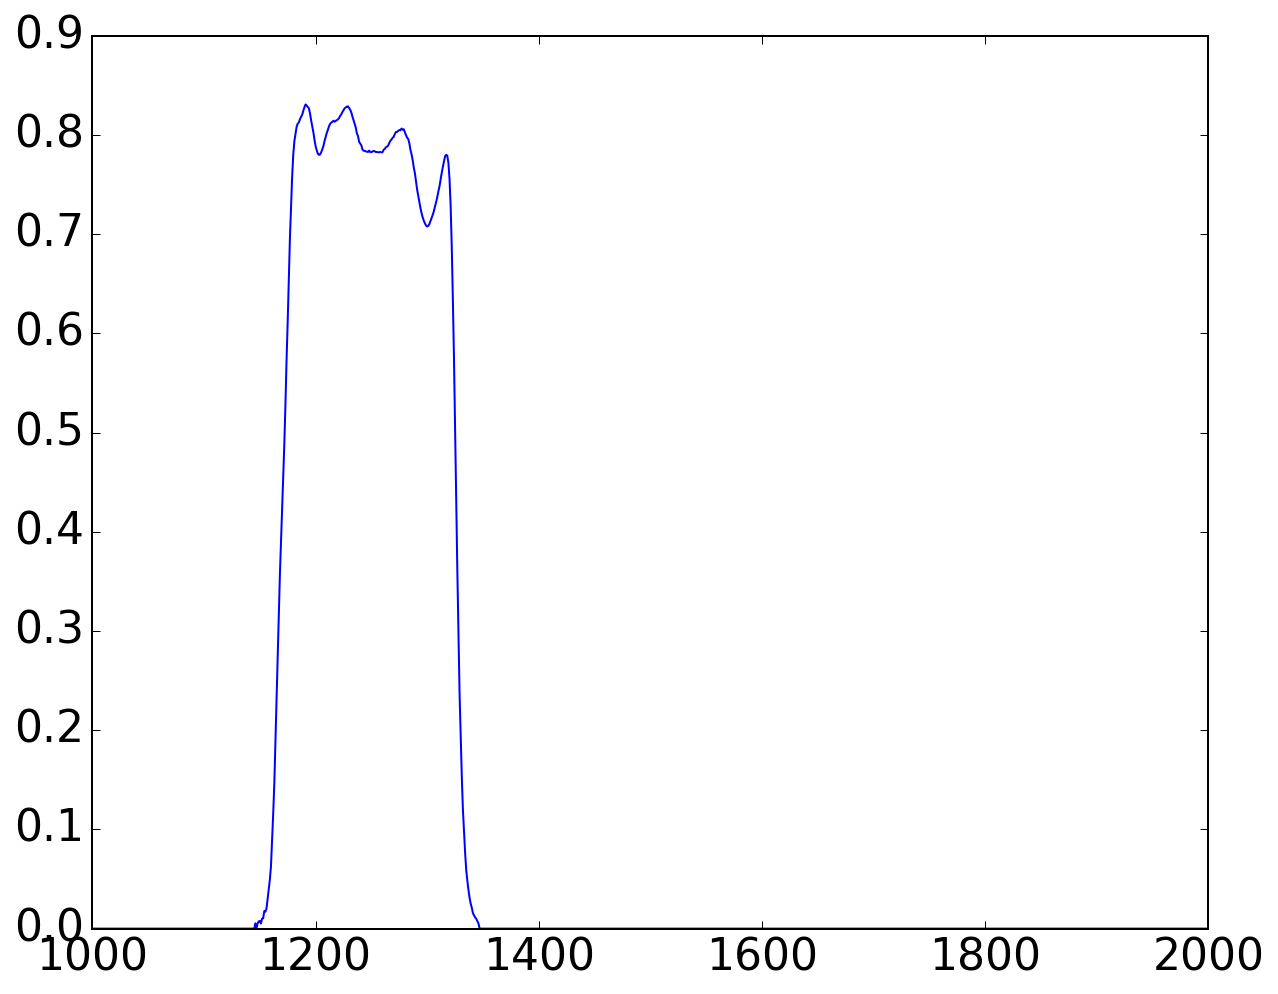

In [83]:
plt.plot(fullLamRange ,jhkFilters['J'](fullLamRange) )
plt.xlim([1000,2000])